## Convolutional Neural Networks

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](https://medium.com/@alexattia18) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://drive.google.com/drive/folders/171GKxRx2SCjLfcfYSPbIa1HzpR6ha3-s?usp=sharing) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://drive.google.com/drive/folders/1B4L6Pk1x9cbfvbP1uQTBSD959_n3QdvL?usp=sharing) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.

Todo el dataset en un solo enlace([Enlace_descarga_completo](https://drive.google.com/file/d/1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La/view?usp=sharing))


## Carga de los datos

In [1]:
from google.colab.patches import cv2_imshow
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tensorflow import keras
import tensorflow as tf

from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, MaxPooling2D
from keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import itertools
import glob
%matplotlib inline

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Ruta base en Drive
DRIVE_BASE_PATH = "/content/drive/MyDrive/DataSets/Deep/Simpsons"

# Crear carpetas en Drive
!mkdir -p "$DRIVE_BASE_PATH"

# Descargar y mover archivo ZIP al Drive
!gdown 1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La -O "$DRIVE_BASE_PATH/archive.zip"
!unzip -q "$DRIVE_BASE_PATH/archive.zip" -d "$DRIVE_BASE_PATH"

# Verificar
!ls -la "$DRIVE_BASE_PATH"

# Nuevas rutas para entrenamiento y test
DATASET_TRAIN_PATH = f"{DRIVE_BASE_PATH}/simpsons_dataset"
DATASET_TEST_PATH = f"{DRIVE_BASE_PATH}/kaggle_simpson_testset"

# Verificar que las carpetas existen
print(f"\nCarpeta de entrenamiento existe: {os.path.exists(DATASET_TRAIN_PATH)}")
print(f"Carpeta de prueba existe: {os.path.exists(DATASET_TEST_PATH)}")

# Contar personajes y mostrar estadísticas si las carpetas existen
if os.path.exists(DATASET_TRAIN_PATH):
    # Comprobar si hay subcarpetas (personajes)
    if any(os.path.isdir(os.path.join(DATASET_TRAIN_PATH, f)) for f in os.listdir(DATASET_TRAIN_PATH)):
        train_classes = [d for d in os.listdir(DATASET_TRAIN_PATH) if os.path.isdir(os.path.join(DATASET_TRAIN_PATH, d))]
        print(f"\nNúmero de personajes en el dataset de entrenamiento: {len(train_classes)}")
        print(f"Ejemplos de personajes: {train_classes[:5]}")

        # Contar imágenes por personaje
        train_images_count = {}
        total_train_images = 0

        for character in train_classes:
            char_path = os.path.join(DATASET_TRAIN_PATH, character)
            images = [f for f in os.listdir(char_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            train_images_count[character] = len(images)
            total_train_images += len(images)

        print(f"Total de imágenes de entrenamiento: {total_train_images}")
        print("\nPersonajes con más imágenes:")
        for char, count in sorted(train_images_count.items(), key=lambda x: x[1], reverse=True)[:18]:
            print(f"{char}: {count} imágenes")
    else:
        print("La carpeta de entrenamiento no parece contener subdirectorios de personajes.")
        print("Contenido de la carpeta de entrenamiento:")
        !ls -la {DATASET_TRAIN_PATH}

if os.path.exists(DATASET_TEST_PATH):
    # Comprobar si hay subcarpetas (personajes) o si es una estructura plana
    if any(os.path.isdir(os.path.join(DATASET_TEST_PATH, f)) for f in os.listdir(DATASET_TEST_PATH)):
        test_classes = [d for d in os.listdir(DATASET_TEST_PATH) if os.path.isdir(os.path.join(DATASET_TEST_PATH, d))]
        print(f"\nNúmero de personajes en el dataset de prueba: {len(test_classes)}")
        print(f"Ejemplos de personajes: {test_classes[:5]}")

        # Contar imágenes totales en prueba
        test_images = 0
        for cls in test_classes:
            test_images += len(os.listdir(os.path.join(DATASET_TEST_PATH, cls)))
        print(f"Total de imágenes de prueba: {test_images}")
    else:
        # Si no hay subcarpetas, contar directamente las imágenes
        test_images = [f for f in os.listdir(DATASET_TEST_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"\nTotal de imágenes de prueba: {len(test_images)}")

# Ahora puedes continuar con tu código para el modelo de clasificación
print("\nConfiguración completa. Puedes proceder con el entrenamiento del modelo.")

Mounted at /content/drive
Downloading...
From (original): https://drive.google.com/uc?id=1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La
From (redirected): https://drive.google.com/uc?id=1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La&confirm=t&uuid=6ec48a06-01f5-4e16-9f85-058d4295e319
To: /content/drive/MyDrive/DataSets/Deep/Simpsons/archive.zip
100% 1.16G/1.16G [00:07<00:00, 153MB/s]
replace /content/drive/MyDrive/DataSets/Deep/Simpsons/annotation.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            # Cargar la imagen en BGR
            image = cv2.imread(os.path.join(dirname, character, image_name))
            # Convertir de BGR a RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Redimensionar la imagen
            X_train.append(cv2.resize(image, (IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [ ]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/content/drive/MyDrive/DataSets/Deep/Simpsons/simpsons_dataset"
DATASET_TEST_PATH_COLAB = "/content/drive/MyDrive/DataSets/Deep/Simpsons/kaggle_simpson_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 0 imágenes de test


In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

# Entrega

## Normalización

In [ ]:
# Normalizamos los datos (valores entre 0 y 1)
X = X.astype('float32') / 255.0
X_t = X_t.astype('float32') / 255.0

y = keras.utils.to_categorical(y, num_classes=18)
y_t = keras.utils.to_categorical(y_t, num_classes=18)

print(f"Shape del set de entrenamiento: {X.shape}")
print(f"Shape del set de test: {X_t.shape}")

print(f"Shape del label de entrenamiento: {y.shape}")
print(f"Shape del label de test: {y_t.shape}")

Shape del set de entrenamiento: (18992, 64, 64, 3)
Shape del set de test: (0,)
Shape del label de entrenamiento: (18992, 18)
Shape del label de test: (0, 18)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print (f"Tamaño de X_train: {X_train.shape}")
print (f"Tamaño de y_train: {y_train.shape}")
print (f"Tamaño de X_test: {X_test.shape}")
print (f"Tamaño de y_test: {y_test.shape}")

Tamaño de X_train: (15193, 64, 64, 3)
Tamaño de y_train: (15193, 18)
Tamaño de X_test: (3799, 64, 64, 3)
Tamaño de y_test: (3799, 18)


In [ ]:
y_classes = np.argmax(y, axis=1)  # de (18992, 18) -> (18992,)
labels_df = pd.DataFrame({'label': y_classes})
labels_df['character'] = labels_df['label'].map(MAP_CHARACTERS)

<ipython-input-11-26ec8b999758>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
<ipython-input-11-26ec8b999758>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


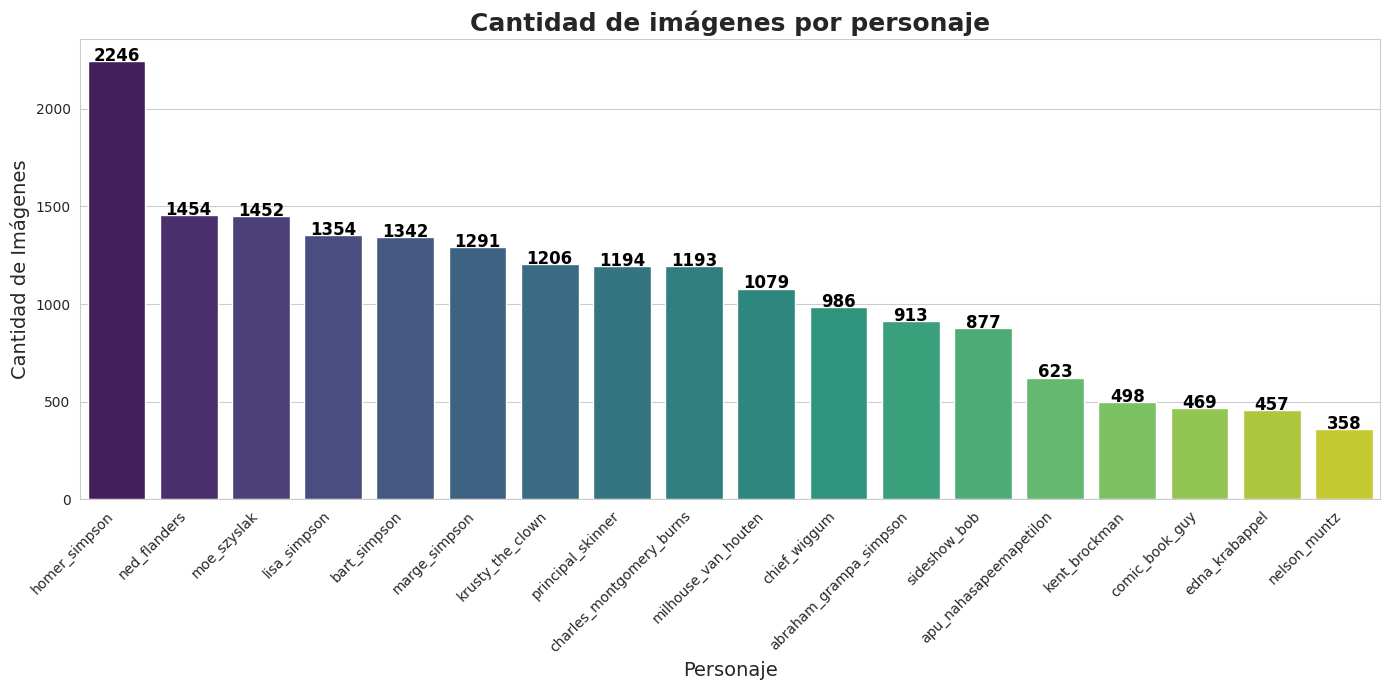

In [ ]:

def plot_character_count(labels_df):
  plt.figure(figsize=(14,7))
  sns.set_style("whitegrid")
  palette = sns.color_palette("viridis", n_colors=len(labels_df['character'].unique()))

  ax = sns.countplot(
    data=labels_df,
    x='character',
    order=labels_df['character'].value_counts().index,
    palette=palette
  )

  # Rotate x-axis labels for readability
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

  # Add title and axis labels with nicer font sizes
  plt.title("Cantidad de imágenes por personaje", fontsize=18, weight='bold')
  plt.xlabel("Personaje", fontsize=14)
  plt.ylabel("Cantidad de Imágenes", fontsize=14)

  # Adding count labels on top of bars
  for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 1,  # little above the bar
      '{:d}'.format(int(height)),
      ha="center", fontsize=12, color='black', weight='semibold')

  plt.tight_layout()
  plt.show()

plot_character_count(labels_df)

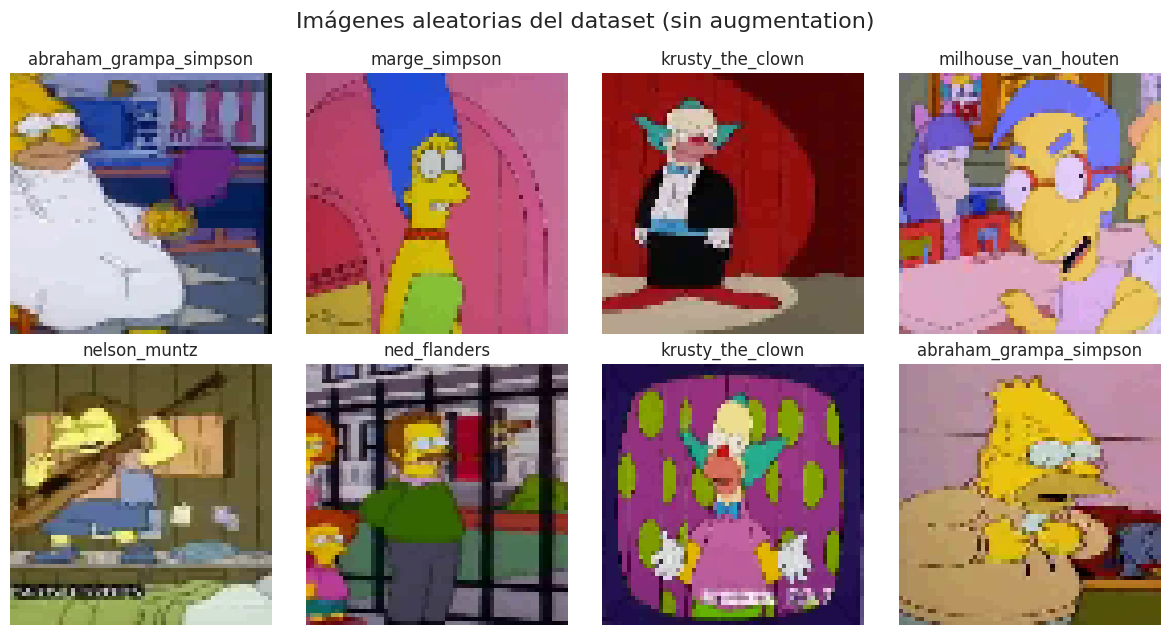

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generar índices aleatorios
random_indices = np.random.choice(len(X_train), size=8, replace=False)

# Pasar etiquetas one-hot a índices
y_train_idx = np.argmax(y_train, axis=1)

# Visualizar 8 imágenes aleatorias del dataset
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_train[idx])
    label_idx = y_train_idx[idx]
    plt.title(MAP_CHARACTERS[label_idx])
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Imágenes aleatorias del dataset (sin augmentation)", y=1.05, fontsize=16)
plt.show()


## Data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 70

# Data augmentation para entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Validación
val_datagen = ImageDataGenerator()

# Generadores de batches
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_test, y_test,
    batch_size=batch_size,
    shuffle=False
)

print(f"Tamaño de train_generator: {len(train_generator)} batches")
print(f"Tamaño de val_generator: {len(val_generator)} batches")

Tamaño de train_generator: 218 batches
Tamaño de val_generator: 55 batches


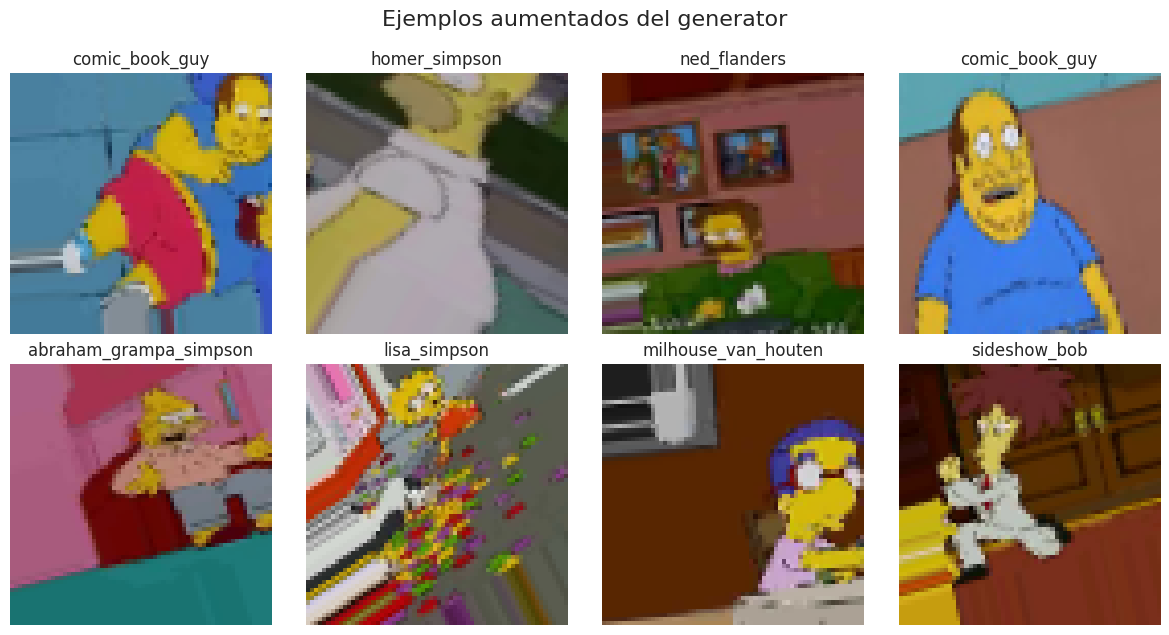

In [ ]:
# Visualizar 8 imágenes augmentadas de una sola clase
import matplotlib.pyplot as plt

# Seleccionamos un batch del generator
x_batch, y_batch = next(train_generator)

# Mostrar las primeras 8 imágenes del batch
plt.figure(figsize=(12,6))
for i in range(8):
  plt.subplot(2, 4, i+1)
  plt.imshow(x_batch[i])
  label_idx = np.argmax(y_batch[i])
  label_name = MAP_CHARACTERS[label_idx]
  plt.title(label_name)
  plt.axis('off')

plt.tight_layout()
plt.suptitle("Ejemplos aumentados del generator", y=1.05, fontsize=16)
plt.show()


## Modelo

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

input_shape = (64, 64, 3)

model = Sequential([
  Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.02), input_shape=input_shape),
  Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.02)),
  MaxPooling2D(2,2),
  Dropout(0.30),

  Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.02)),
  Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.02)),
  MaxPooling2D(2,2),
  Dropout(0.30),

  Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.02)),
  Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.02)),
  MaxPooling2D(2,2),
  Dropout(0.30),

  Flatten(),

  Dense(1024, activation='relu', kernel_regularizer=l2(0.02)),
  Dropout(0.3),

  Dense(18, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │        18,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,695,090 (33.17 MB)

 Trainable params: 8,695,090 (33.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.02), input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.30),

    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.30),

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Dropout(0.30),
    Flatten(),

    Dense(512, activation='relu',kernel_regularizer=l2(0.02)),
    Dropout(0.5),

    Dense(18, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,298,194 (16.40 MB)

 Trainable params: 4,297,746 (16.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
import datetime
import time
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Carpeta base con timestamp
log_dir = "/content/drive/MyDrive/DataSets/Deep/simpsons/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir, exist_ok=True)

# Subcarpetas para checkpoints y logs de tensorboard
checkpoint_dir = os.path.join(log_dir, "checkpoint")
tensorboard_log_dir = os.path.join(log_dir, "log")

os.makedirs(checkpoint_dir, exist_ok=True)

# Instanciar callbacks
callback = []

tensorboard_callback = TensorBoard(
    log_dir=tensorboard_log_dir, # Ruta para guardar perdida y presición.
    histogram_freq=1, # Cada epoca guarda los datos
    write_graph= True # Guarda la arquitectura del modelo
)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model_epoch.keras"),  # Ruta para guardar el mejor modelo
    monitor="val_accuracy",  # Monitorear la precisión de validación.
    save_best_only=True,  # Guardar solo el mejor modelo.
    save_weights_only=False,  # Guardar todo el modelo (no solo los pesos).
    verbose=1 # Mostrar texto.
)

early_stop_callback = EarlyStopping(
    monitor="val_loss", # Monitorear la pérdida de validación.
    patience=10, # Detener luego de 10 intentos sin mejora.
    restore_best_weights=True # Restaurar los pesos del mejor modelo.
)

# lr_scheduler_callback  = ReduceLROnPlateau(
#     monitor="val_loss", # Monitorear la pérdida de validación.
#     factor=0.2, # Reducir la tasa de aprendijaze en un 50% cuando no exista mejora.
#     patience=5, # Esperar 5 epocas sin mejora en la pérdida de validación
#     verbose=1, # Mostrar texto
#     min_lr=0.0001 # Tasa de aprendizaje mínima
# )

callback.append(tensorboard_callback)
callback.append(checkpoint_callback)
callback.append(early_stop_callback)
# callback.append(lr_scheduler_callback)

# Configurar parámetros de entrenamiento
# batch_size = 100
# epochs = 40
# validation_data = (X_test, Y_test)
# shuffle = True

In [ ]:
import time
start_time = time.time()

epochs = 40

history = model.fit(
    train_generator,
    epochs= epochs,
    validation_data= val_generator,
    callbacks=callback
)

end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos, {training_time/60:.2f} minutos")

# Mejor val_accuracy
print(f"Mejor val_accuracy: {np.max(history.history['val_accuracy']):.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.1144 - loss: 24.6554
Epoch 1: val_accuracy improved from -inf to 0.02264, saving model to /content/drive/MyDrive/DataSets/Deep/simpsons/20250515-212121/checkpoint/best_model_epoch.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 44s 150ms/step - accuracy: 0.1145 - loss: 24.6474 - val_accuracy: 0.0226 - val_loss: 24.5241
Epoch 2/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2003 - loss: 18.7066
Epoch 2: val_accuracy improved from 0.02264 to 0.18215, saving model to /content/drive/MyDrive/DataSets/Deep/simpsons/20250515-212121/checkpoint/best_model_epoch.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 65s 112ms/step - accuracy: 0.2003 - loss: 18.7010 - val_accuracy: 0.1822 - val_loss: 16.4321
Epoch 3/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2573 - loss: 14.1155
Epoch 3: val_accuracy improved from 0.18215 to 0.40011, saving model to /content/drive/MyDrive/DataSets/Deep/simpsons/20250515-212121/checkpoint/best_model_ep

# Implementacion gradio


**Implementamos gradio con un pip**

In [3]:
!pip install gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import numpy as np
import cv2
from tensorflow.keras.models import load_model


# 3. Ruta del modelo entrenado en tu Drive
model_path = "/content/drive/MyDrive/DataSets/Deep/simpsons/20250515-212121/checkpoint/best_model_epochmati.keras"
model = load_model(model_path)


# 4. Diccionario de mapeo de clases
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}


IMG_SIZE = 64  # Tamaño estándar del modelo


# 5. Función de predicción
def predict_character(image):
    # Gradio ya entrega imagen RGB como NumPy array (no usar cv2.imread ni cvtColor)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Solo redimensionar
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)


    prediction = model.predict(image)[0]
    top_indices = prediction.argsort()[-3:][::-1]


    result = "Top 3 predicciones:\n"
    for i in top_indices:
        nombre = MAP_CHARACTERS[i]
        prob = prediction[i] * 100
        result += f"{nombre}: {prob:.2f}%\n"
    return result




# 6. Crear interfaz Gradio
interface = gr.Interface(
    fn=predict_character,
    inputs=gr.Image(type="numpy", label="Sube una imagen de un personaje"),
    outputs="text",
    title="🧠 Clasificador de Personajes de Los Simpsons",
    description="Carga una imagen y el modelo CNN predirá el personaje más probable."
)


# 7. Lanzar Gradio
interface.launch(share=True)  # Puedes cambiar share=False si no quieres link externo

**Crear la intergaz de gradio**

In [ ]:
import gradio as gr
import cv2
import numpy as np
import tempfile
import subprocess
from tensorflow.keras.models import load_model



IMG_SIZE =64
model_path = "/content/drive/MyDrive/DataSets/Deep/simpsons/20250515-212121/checkpoint/best_model_epochmati.keras"
model = load_model(model_path)


MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}


face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


PERSIST_FRAMES = 15
CONF_THRESHOLD = 0.65  # 65% confianza mínima para mostrar etiqueta


def predict_character(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image, verbose=0)[0]
    top_indices = prediction.argsort()[-3:][::-1]
    best_id = top_indices[0]
    best_label = MAP_CHARACTERS[best_id]
    best_conf = prediction[best_id]
    return best_label, best_conf, top_indices, prediction


def is_near(box1, box2, threshold=50):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    center1 = (x1 + w1/2, y1 + h1/2)
    center2 = (x2 + w2/2, y2 + h2/2)
    dist = np.sqrt((center1[0]-center2[0])**2 + (center1[1]-center2[1])**2)
    return dist < threshold


def add_margin(box, margin, max_width, max_height):
    x, y, w, h = box
    x_new = max(0, x - margin)
    y_new = max(0, y - margin)
    w_new = min(w + 2*margin, max_width - x_new)
    h_new = min(h + 2*margin, max_height - y_new)
    return (x_new, y_new, w_new, h_new)


def process_video(video):
    input_path = video.name


    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise ValueError("No se pudo abrir el video.")


    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0 or width == 0 or height == 0:
        fps = 20


    temp_avi = tempfile.NamedTemporaryFile(delete=False, suffix=".avi")
    avi_path = temp_avi.name
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(avi_path, fourcc, fps, (width, height))


    if not out.isOpened():
        raise ValueError("No se pudo iniciar VideoWriter.")


    tracked_faces = []


    while True:
        ret, frame = cap.read()
        if not ret:
            break


        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)


        updated_tracked = []


        for (x, y, w, h) in faces:
            # Agregar margen para no cortar la cara
            x_m, y_m, w_m, h_m = add_margin((x, y, w, h), margin=10, max_width=width, max_height=height)
            roi = frame[y_m:y_m+h_m, x_m:x_m+w_m]


            try:
                label, conf, _, _ = predict_character(roi)


                if conf < CONF_THRESHOLD:
                    continue  # No dibujar si confianza baja


                matched = False
                for tf in tracked_faces:
                    if is_near((x_m, y_m, w_m, h_m), tf['box']):
                        tf['box'] = (x_m, y_m, w_m, h_m)
                        tf['label'] = label
                        tf['conf'] = conf
                        tf['frames_left'] = PERSIST_FRAMES
                        updated_tracked.append(tf)
                        matched = True
                        break
                if not matched:
                    updated_tracked.append({
                        'box': (x_m, y_m, w_m, h_m),
                        'label': label,
                        'conf': conf,
                        'frames_left': PERSIST_FRAMES
                    })
            except Exception as e:
                print(f"Error en predicción: {e}")


        # Mantener caras no detectadas pero aún visibles (persistencia)
        for tf in tracked_faces:
            if tf not in updated_tracked:
                tf['frames_left'] -= 1
                if tf['frames_left'] > 0:
                    updated_tracked.append(tf)


        # Dibujar etiquetas
        for tf in updated_tracked:
            x, y, w, h = map(int, tf['box'])
            label = tf['label']
            conf = tf['conf']
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, f"{label} ({conf*100:.1f}%)", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)


        tracked_faces = updated_tracked
        out.write(frame)


    cap.release()
    out.release()


    # Convertir AVI a MP4 para compatibilidad
    temp_mp4 = tempfile.NamedTemporaryFile(delete=False, suffix=".mp4")
    mp4_path = temp_mp4.name


    import subprocess
    ffmpeg_command = [
        'ffmpeg', '-y', '-i', avi_path,
        '-vcodec', 'libx264',
        '-pix_fmt', 'yuv420p',
        mp4_path
    ]
    subprocess.run(ffmpeg_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


    return mp4_path


iface = gr.Interface(
    fn=process_video,
    inputs=gr.File(label="Sube un video MP4", file_types=[".mp4"]),
    outputs=gr.Video(label="Video procesado"),
    title="🎬 Clasificador Mejorado de Simpsons en Video",
    description="Detecta rostros, aplica modelo probado con imágenes y filtra predicciones con baja confianza."
)


iface.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1f1bb5401e6e4d0cab.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
print(MAP_CHARACTERS)
print(model.predict(np.zeros((1, 64, 64, 3))))  # Solo para ver que devuelve un array de 18 clases


{0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
[[3.8636215e-02 3.8844845e-03 2.6978161e-03 1.6909307e-02 1.1630835e-02
  6.8772171e-04 4.3811852e-01 1.5447104e-01 1.8014654e-05 1.0764145e-01
  6.5431051e-02 5.5564351e-02 1.3791566e-04 4.4094645e-03 8.3664386e-03
  1.5474351e-03 5.4712377e-02 3.5135623e-02]]


In [ ]:
from keras.models import load_model

model_path = "/content/drive/MyDrive/DataSets/Deep/simpsons/20250515-212121/checkpoint/saved_model_simpsons.keras"
model = load_model(model_path)

print("Modelo cargado correctamente")


KeyError: "There is no item named 'config.json' in the archive"